In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# トイデータの作成

In [2]:
df = pd.DataFrame([])
x1 = []
x1 += list(np.random.uniform(0,20,10))
x1 += list(np.random.uniform(10,30,10))
x1 += list(np.random.uniform(20,40,10))
x1 += list(np.random.uniform(30,50,10))
x1 += list(np.random.uniform(40,60,10))
df["x1"] = x1
x2 = []
x2 += list(np.random.uniform(10,30,10))
x2 += list(np.random.uniform(20,40,10))
x2 += list(np.random.uniform(10,30,10))
x2 += list(np.random.uniform(30, 60,10))
x2 += list(np.random.uniform(0,30,10))
df["x2"] = x2
y = []
y += ["a"]*10
y += ["b"]*10
y += ["c"]*10
y += ["d"]*10
y += ["e"]*10
df["y"] = y

/Users/nobu/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


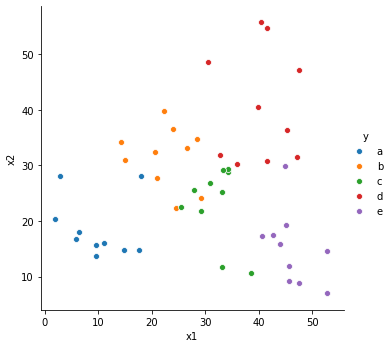

In [3]:
import seaborn as sns
sns.pairplot(x_vars=["x1"], y_vars=["x2"], data=df, hue="y", size=5)

## シンプルな決定木を実装する

In [4]:
df.head()

,x1,x2,y
0,9.635302,13.607068,a
1,1.894932,20.397469,a
2,18.064188,28.172856,a
3,14.799798,14.752606,a
4,9.648572,15.584423,a


In [5]:
from pandas.api.types import is_numeric_dtype
def is_numeric(df, col):
    return is_numeric_dtype(df[col])

In [6]:
class Partition:
    def __init__(self, column, value):
        self.column = column
        self.value = value
    def split_df(self, df):
        v = df[self.column]
        if is_numeric(df, self.column):
            return df[v <= self.value], df[v > self.value]
        else:
            return df[v == self.value], df[v != self.value]

In [7]:
p = Partition("x1", 30)

In [8]:
df_left, df_right = p.split_df(df)

## ジニ不純度(Gini impurity)の計算

$I_{G}(t)=1 - \sum_{c=1}^n p(c|t)^2$

$p(c|t)$: クラスcに属するサンプル割合

In [9]:
def gini(df_partitioned, target_col):
    counts = df_partitioned[target_col].value_counts()
    gini = 1
    for k, v in counts.iteritems():
        gini -= (v/len(df_partitioned))**2
    return gini

In [10]:
gini(df_left, "y")

0.604914933837429

In [11]:
df_toy = df[df["y"] == "a"]
gini(df_toy, "y")

0.0

In [12]:
gini(df, "y")

0.7999999999999998

## information gainを計算する
dataframeを二つに分けて、不純度の変化を計算する

In [13]:
def information_gain(left, right, current_impurity, target):
    p = float(len(left))/(len(left)+len(right))
    gain = current_impurity - (p*gini(left, target) + (1-p)*gini(right, target))
    return gain

In [14]:
first_impurity = gini(df, "y")
p = Partition("x1", 30)
df_left, df_right = p.split_df(df)
information_gain(df_left, df_right, first_impurity, "y")

0.16618357487922686

## 最適なsplitを探索する

In [15]:
def find_best_split(df, target):
    max_gain = 0
    best_split = None
    current_impurity = gini(df, target)
    columns = [e for e in df.columns.tolist() if e != target]
    for col in columns:
        values = set(df[col].values)
        for value in values:
            # gainを計算して、最大のgainを記録していく
            p = Partition(col, value)
            df_left, df_right = p.split_df(df)
            if len(df_left) == 0 or len(df_right) == 0:
                continue
            gain = information_gain(df_left, df_right, current_impurity, target)
            if gain > max_gain:
                max_gain = gain
                best_split = [col, value]
    return best_split, max_gain

In [16]:
best_split, max_gain = find_best_split(df, "y")

In [17]:
max_gain

0.16618357487922686

In [18]:
best_split

['x1', 29.285124621445352]

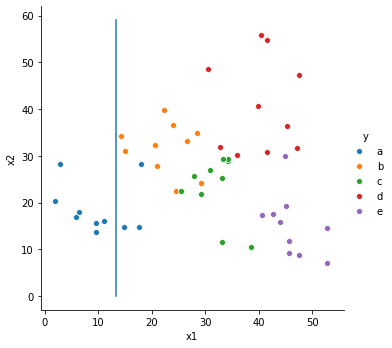

In [19]:
import seaborn as sns
sns.pairplot(x_vars=["x1"], y_vars=["x2"], data=df, hue="y", size=5)
plt.plot( [13.312367639178948 for e in range(60)], [e for e in range(0, 60)])

## 決定木の構築

In [20]:
# 決定木の最後の葉っぱの部分。decisoin nodeで分割されたあと、gainが0になった地点
# Leafに残っているデータのクラスごとのカウントの割合を、予測結果にする
# {a: 10%, b: 70%, c: 20%}のように

class Leaf:
    def __init__(self, df, target):
        self.results = df[target].value_counts()/len(df)*100

class DecisionNode:
    def __init__(self, best_split, left_decision, right_decision):
        self.best_split = best_split
        self.left_decision = left_decision
        self.right_decision = right_decision

In [21]:
def make_decision_tree(df, target):
    # 再帰的に決定技を構築する
    best_split, gain = find_best_split(df, target)
    if gain == 0 or gain is None:
        return Leaf(df, target)
    p = Partition(*best_split)
    left, right = p.split_df(df)
    left_decision = make_decision_tree(left, target)
    right_decision = make_decision_tree(right, target)
    return DecisionNode(best_split, left_decision, right_decision)

In [22]:
tree = make_decision_tree(df, "y")

In [23]:
def predict(node, df):
    # node; Leaf, DecisionNode
    if isinstance(node, Leaf):
        return node.results
    col, value = node.best_split
    if is_numeric(df, col):
        if df[col] <= value:
            return predict(node.left_decision, df)
        else:
            return predict(node.right_decision, df)
    else:
        if df[col] == value:
            return predict(node.left_decision, df)
        else:
            return predict(node.right_decision, df)

In [24]:
df.iloc[0]

x1     9.6353
x2    13.6071
y           a
Name: 0, dtype: object

In [25]:
predict(tree, df.iloc[0])

a    100.0
Name: y, dtype: float64

## testしてみる

In [26]:
df_test = pd.DataFrame([])
x1 = []
x1 += list(np.random.uniform(0,20,10))
x1 += list(np.random.uniform(10,30,10))
x1 += list(np.random.uniform(20,40,10))
x1 += list(np.random.uniform(30,50,10))
x1 += list(np.random.uniform(40,60,10))
df_test["x1"] = x1
x2 = []
x2 += list(np.random.uniform(10,25,10))
x2 += list(np.random.uniform(25,40,10))
x2 += list(np.random.uniform(0,30,10))
x2 += list(np.random.uniform(30, 35,10))
x2 += list(np.random.uniform(13,17,10))
df_test["x2"] = x2
y = []
y += ["a"]*10
y += ["b"]*10
y += ["c"]*10
y += ["d"]*10
y += ["e"]*10
df_test["y"] = y

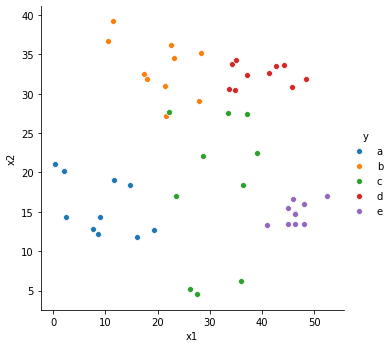

In [27]:
import seaborn as sns
sns.pairplot(x_vars=["x1"], y_vars=["x2"], data=df_test, hue="y", size=5)

In [28]:
correct = 0
for i in range(len(df_test)):
    if predict(tree, df_test.iloc[i]).index[0] == df_test.iloc[i]["y"]:
        correct += 1
correct/len(df_test)

0.9

## 追記
学習データには、overfitしている

In [29]:
correct = 0
for i in range(len(df)):
    if predict(tree, df.iloc[i]).index[0] == df.iloc[i]["y"]:
        correct += 1
correct/len(df_test)

1.0